This notebooks sets up a machine learning model using features and target, defined during the previous steps.

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
import time
import json
import datetime
import pyltr
from tqdm import tqdm
from pandas.io.json import json_normalize
from scipy import stats
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import Imputer, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.neighbors import KernelDensity
strptime = datetime.datetime.strptime
plt.rcParams['figure.figsize'] = (16, 4)

In [26]:
df_n = pd.read_csv('df_n.csv', index_col=0)
df_geo = pd.read_csv('df_geo.csv', index_col=0)
df_opened = pd.read_csv('df_opened.csv', index_col=0)
df_rating = pd.read_csv('df_rating.csv', index_col=0)

In [27]:
target = pd.read_csv('target.csv', index_col=0)['target']

Our features and target span over different stores. Here, we take stores which are common to all data sets and limit the data sets to those stores.

In [28]:
ix = sorted(set.intersection(
    set(df_n.index), set(df_geo.index), set(df_opened.index),
    set(df_rating.index), set(target.index)
))

In [29]:
df_n = df_n.reindex(ix)
df_geo = df_geo.reindex(ix)
df_opened = df_opened.reindex(ix)
df_rating = df_rating.reindex(ix)
target = target.reindex(ix)

In [30]:
# check for duplicated store codes
for d in [df_n, df_geo, df_opened, df_rating, target]:
    print(d.index.duplicated().sum())

0
0
0
0
0


In [31]:
# check for null values
for d in [df_n, df_geo, df_opened, df_rating, target]:
    print(d.isnull().sum().sum())

0
62204
249844
42338
0


# Preprocessing

First, we plot the number of amenities present versus target. We see that for many amenity types, the number of amenities is uniform across all stores.

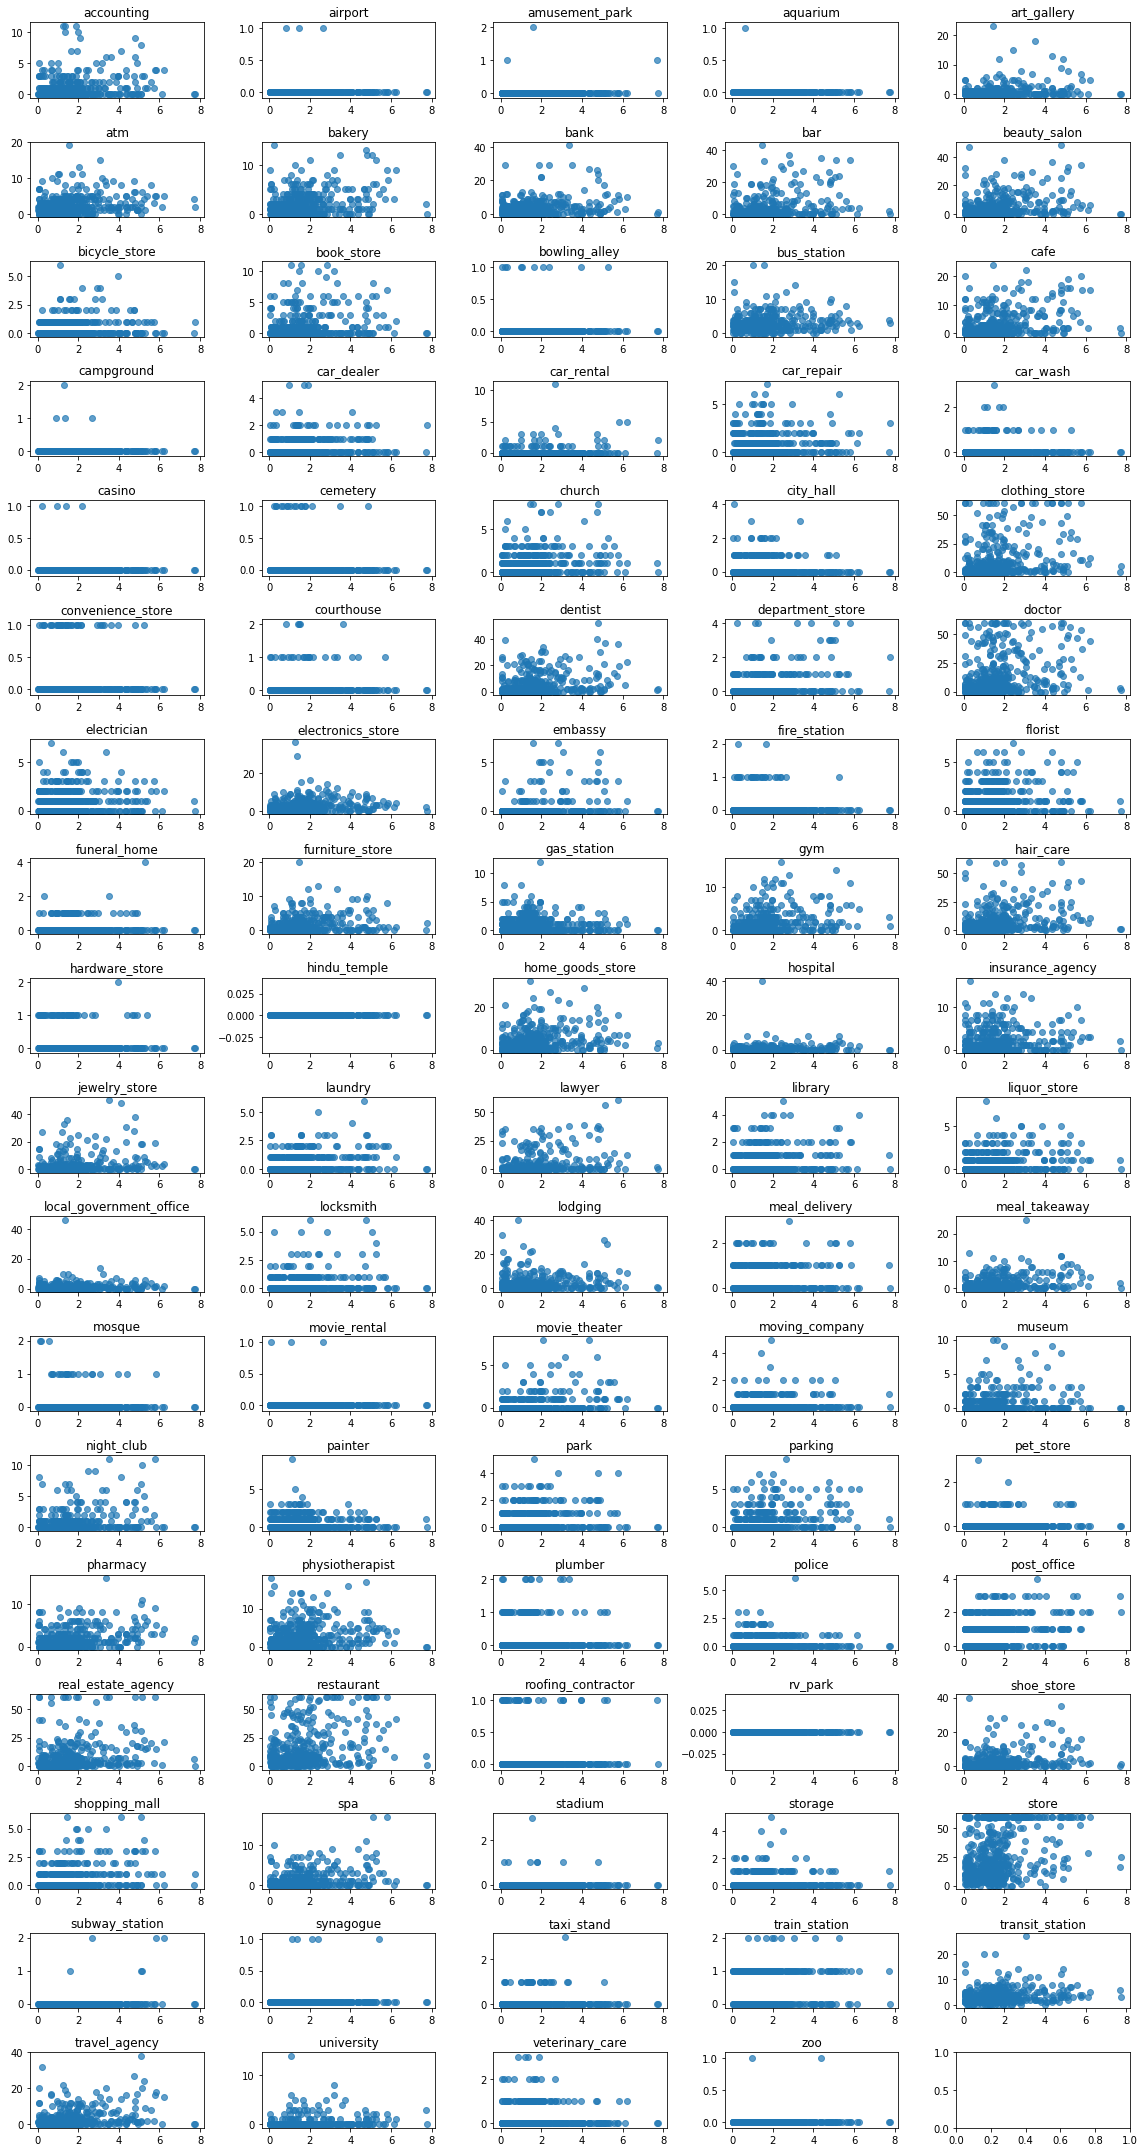

In [13]:
fig, axes = plt.subplots(18, 5, figsize=(16, 30))
axes = axes.ravel()

for c, ax in zip(df_n.columns, axes):
    ax.scatter(target, df_n[c], alpha=0.7)
    ax.set_title(c)
    
fig.tight_layout()

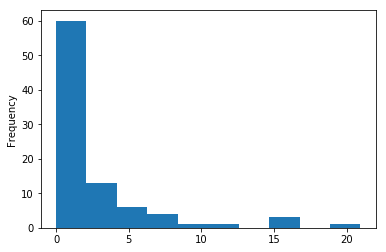

In [36]:
df_n.std().plot.hist()

We filter out amenities with low standard deviation of their count.

In [37]:
df_n = df_n.loc[:, df_n.std() > 1]

In [33]:
df_geo.shape

(532, 178)

Similarly, we look at distribution of latitudes and longitudes, and filter out those with low std.

In [39]:
df_lat = df_geo[[i for i in df_geo if '_latitude' in i]]

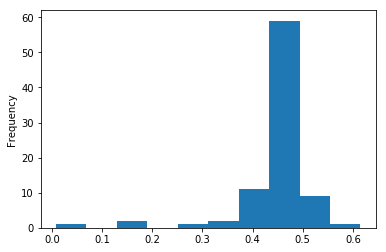

In [40]:
df_lat.std().plot.hist()

In [41]:
df_lat = df_lat.loc[:, df_lat.std() > 0.3]

In [42]:
df_lon = df_geo[[i for i in df_geo if '_longitude' in i]]

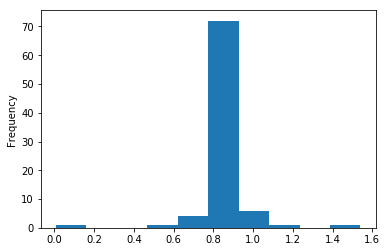

In [43]:
df_lon.std().plot.hist()

In [44]:
df_lon = df_lon.loc[:, df_lon.std() > 0.5]

We also want to filter out amenities with high number of unknown geocoordinates.

In [58]:
n = df_lat.isnull().sum() / len(df_lat)
df_lat = df_lat.loc[:, n > 0.8]

In [59]:
n = df_lon.isnull().sum() / len(df_lon)
df_lon = df_lon.loc[:, n > 0.8]

Similar procedue is done with the opening times.

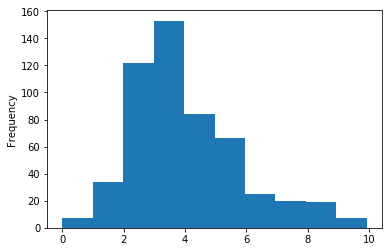

In [47]:
df_opened.std().plot.hist()

In [61]:
n = df_opened.isnull().sum() / len(df_opened)
df_opened = df_opened.loc[:, n > 0.8]

In general, we will use mean imputation where values are not known. However, in case of total open times, we can go a step further. We know that if a total open time is absent, then there are no amenities of a given type, which means that total open time is essentially zero.

In [74]:
df_opened = df_opened.fillna(0)

Finally, remove amenities with low presence of rating information.

In [66]:
n = df_rating.isnull().sum() / len(df_rating)

In [68]:
df_rating = df_rating.loc[:, n > 0.8]

Join all data sets together and remove constant features.

In [272]:
df = df_n.join(df_lat).join(df_lon).join(df_opened).join(df_rating)

In [275]:
df = df.loc[:, df.std() > 0]

# Modeling

## Regression

Now for modeling we explore multiple techniques. First, we can try regression trying to predict our continuous variable.

In [277]:
xtrain, xtest, ytrain, ytest = train_test_split(df, target, train_size=0.5, random_state=0)

c:\miniconda2\envs\python3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [278]:
reg = make_pipeline(
    Imputer(), # imputes with mean
    RandomForestRegressor(random_state=0, n_estimators=100) # RF because our features are largely ordinal
)
reg.fit(xtrain, ytrain)

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_s...estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [279]:
pred = pd.Series(reg.predict(xtest), index=xtest.index)

Plot feature importances:

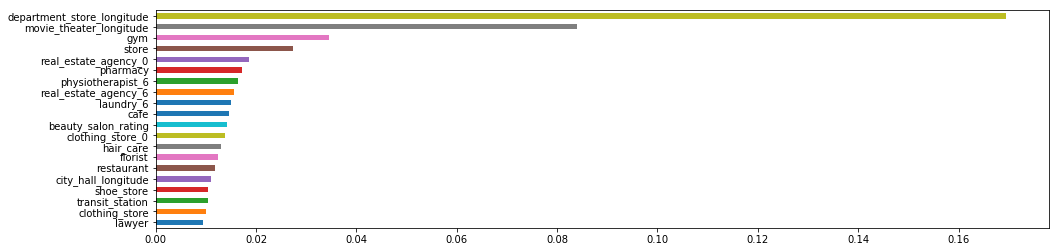

In [280]:
imp = reg.steps[0][-1]

cols = xtrain.columns[np.argwhere(~pd.isnull(imp.statistics_)).flatten()]

pd.Series(reg.steps[-1][-1].feature_importances_, 
          index=df.columns[np.argwhere(~pd.isnull(imp.statistics_)).flatten()]
).sort_values().tail(20).plot.barh()

Looking at the performance, we see that our predict scores are distributed roughly around the center of true scores, and many extremes and under/overpredicted.

MSE 1.685090518515637


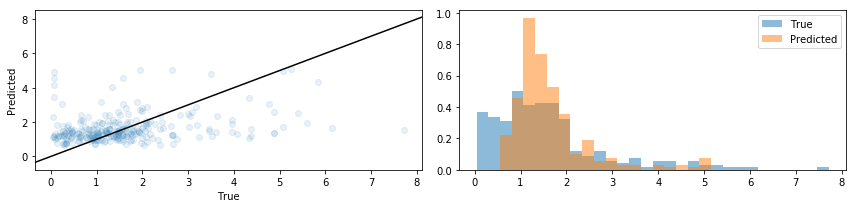

In [317]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 3))
axes = axes.ravel()

ax = axes[0]
ax.scatter(ytest, pred, alpha=0.1)
print('MSE', mean_squared_error(ytest, pred))
vmin, vmax = ax.get_xlim()
ax.plot([vmin, vmax], [vmin, vmax], color='k')
ax.set_xlim(vmin, vmax);
ax.set_xlabel('True')
ax.set_ylabel('Predicted');

ax = axes[1]
bins = np.histogram(ytest, bins=30)[1]
ax.hist(ytest, density=1, alpha=0.5, bins=bins, label='True');
ax.hist(pred, density=1, alpha=0.5, bins=bins, label='Predicted');
ax.legend()

fig.tight_layout()

We can compare this we random predictions taken from the distribution of training target.

In [151]:
kde = KernelDensity()
kde.fit(target.values.reshape(-1, 1));
pred0 = kde.sample(len(ytest)).flatten()

In [152]:
print('MSE', mean_squared_error(ytest, pred0))

MSE 4.205658499275448


## Classification

Alternatively, we can try splitting our target into groups and using classification. We use median as our split threshold.

In [282]:
xtrain, xtest, ytrain, ytest = train_test_split(df, target > target.median(), train_size=0.5, random_state=0)

c:\miniconda2\envs\python3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [289]:
clf = make_pipeline(
    Imputer(),
    RandomForestClassifier(random_state=0, n_estimators=100)
)
clf.fit(xtrain, ytrain);

In [290]:
proba = pd.Series(clf.predict_proba(xtest)[:, 1], index=xtest.index)

The performance is slighly better than average but not too reassuring.

ROC AUC 0.6329751131221719


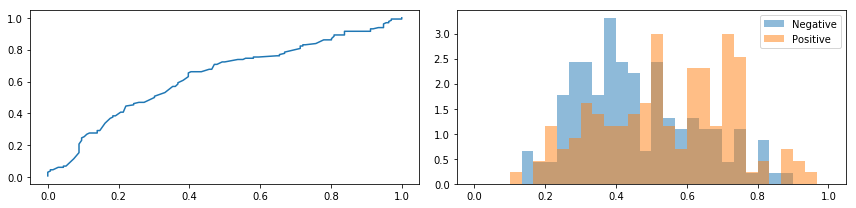

In [291]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 3))
axes = axes.ravel()

ax = axes[0]
fpr, tpr, th = roc_curve(ytest, proba)
ax.plot(fpr, tpr)
print('ROC AUC', roc_auc_score(ytest, proba))

ax = axes[1]
bins = np.histogram(ytest, bins=30)[1]
ax.hist(proba[ytest == 0], density=1, alpha=0.5, bins=bins, label='Negative');
ax.hist(proba[ytest == 1], density=1, alpha=0.5, bins=bins, label='Positive');
ax.legend()

fig.tight_layout();

## Ranking

Classification result was mediocre but it is useful in case the exact sales volume is not important, but we'd rather just know relative potential of a given location. In other words, if sales volumes of store A are twice the sales volumes of store B, we only need to know that sales volumes of A are higher and that's a location where we'd like to open new store. In this situation, splitting training data into high and low groups provides polarization to the classifier in order to output meaningful scores. The exact magnitude of scores is not important - we would just like to use them to rank our training instances .

One of metrics can be used for this purpose is normalized discounted cumulative gain (nDCG). nDCG (at k) is commonly used in ranking problems and is defined as

$$ \mathrm{nDCG_k} = \frac{DCG_k}{IDCG_k} $$

where $DCG$ is discounted cumulative gain and $IDCG$ is ideal discounted cumulative gain. DCG, in turn, is defined as

$$ \mathrm{DCG_k} = \sum_{i=1}^{k}{\frac{2^{r_i}-1}{\log_2(i+1)}} $$

where the sum goes over top $k$ items sorted by their predicted relevance, $r_i$ is the true relevance of position $i$ and IDCG is the DCG of perfectly sorted items.

Let's compare nDCG for our regression and classification cases:

In [452]:
rs = 0

In [453]:
# impute before splitting
xtrain, xtest, ytrain, ytest = train_test_split(Imputer().fit_transform(df), target, train_size=0.5, random_state=rs)

c:\miniconda2\envs\python3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [454]:
reg = RandomForestRegressor(random_state=rs, n_estimators=100)
reg.fit(xtrain, ytrain)
pred = reg.predict(xtest)

In [455]:
metric = pyltr.metrics.NDCG(k=30) # assume we want to focus on 30 new locations

In [456]:
metric.evaluate_preds(0, ytest.values, pred)

0.23139706810965535

In [457]:
metric.evaluate_preds(0, ytest.values, proba)

0.1556382491980694

We use LambdaMART algorithm designed for ranking problems, provided by the `pyltr` packages.

In [458]:
monitor = pyltr.models.monitors.ValidationMonitor(
    xtest, ytest, [0] * len(xtest), metric=metric, stop_after=100
)

model = pyltr.models.LambdaMART(
    metric=metric,
    n_estimators=1000,
    learning_rate=0.02,
    max_features=1.,
    subsample=1,
    query_subsample=1.,
    max_leaf_nodes=10,
    min_samples_leaf=64,
    verbose=1,
    random_state=rs
)

In [459]:
model.fit(xtrain, ytrain, [0] * len(xtrain), monitor=monitor)

 Iter  Train score    Remaining                           Monitor Output 
    1       0.0128        1.04m      C:      0.0068 B:      0.0068 S:  0
    2       0.2711        1.04m      C:      0.1133 B:      0.1133 S:  0
    3       0.2993        1.04m      C:      0.1262 B:      0.1262 S:  0
    4       0.2993       58.36s      C:      0.1262 B:      0.1262 S:  1
    5       0.2993       59.08s      C:      0.1262 B:      0.1262 S:  2
    6       0.2993       56.95s      C:      0.1262 B:      0.1262 S:  3
    7       0.2993       57.64s      C:      0.1262 B:      0.1262 S:  4
    8       0.2993       56.19s      C:      0.1262 B:      0.1262 S:  5
    9       0.2993       56.78s      C:      0.1262 B:      0.1262 S:  6
   10       0.2993       55.69s      C:      0.1262 B:      0.1262 S:  7
   15       0.4014       54.39s      C:      0.1185 B:      0.1262 S: 12
   20       0.4014       53.60s      C:      0.1185 B:      0.1262 S: 17
   25       0.4014       52.41s      C:      0.118

In [460]:
pred2 = model.predict(xtest)

In [461]:
metric.evaluate_preds(0, ytest.values, pred2)

0.19835672693805792

LambdaMART provides performance better than classification but lower than regression.

Performance metrics, especially in a high-dimensional cases like this, are subject to random seed. It is therefore advisory to do investigate effect of the random seed on regression, classification and ranking models.

# Potential improvements

Other things that can be tried:
- investigate effects of different random seeds
- different threshold for standard deviation and null counts to discard
- different imputation of nulls
- more rigorous feature selection (backward selection, genetic algorithms)
- dimensionality reduction (PCA, MCA)
- more rigurous hyperparameter selection (grid search, random search, bayesian optimization)
- removal of outliers (kernel density estimation, clustering techniques) 
- data normalization

Regression:
- different transform of a target variable

Classification:
- different definition of classes (extreme quantiles, multiclass)

Things to consider when going to production:
- more robust checks for data validity
- preprocessing steps to be written as pipeline components, because they rely on saved parameters when transforming unseen data